The other Notebook became a bit much, so I'll be working on visualisations in this Notebook, copying the main functions from `MR-analyse-proximus-mobility-data.ipynb`

# Calculating baseline $P^{gh}$

In [43]:
from datetime import date, datetime, timedelta
# import pandas as pd
import numpy as np
import glob
%matplotlib notebook
import matplotlib.pyplot as plt
import sys
import datetime
# sys.path.insert(0, "../tools")
from covid19model.data.mobility import * # contains all necessary functions

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# First load the data and inspect the mobility for this date range

### FILL IN AGGREGATION ###

agg = 'arr'
filename = 'fractional-mobility-matrix_staytime_' + agg + '_'
data_location = '../../data/interim/mobility/' + agg + '/staytime/'

from datetime import date, datetime, timedelta
dates_prelockdown=[]
dates_prelockdown_datetime=[]

# Define date range
sdate = datetime(2020, 2, 10, 0, 0)   # start date
edate = datetime(2020, 3, 15, 0, 0)   # end date
delta = edate - sdate       # as timedelta

# Fill arrays with YYYYMMDD dates and datetime dates
for i in range(delta.days + 1):
    day = sdate + timedelta(days=i)
    dates_prelockdown_datetime.append(day)
    dates_prelockdown.append(date_to_YYYYMMDD(day))
    
# Load dictionary with YYYYMMDD dates as keys and P-matrices as values
mmprox_prelockdown, missing_dates = load_Pmatrix_staytime(dates_prelockdown, data_location, \
                                        complete=False, verbose=True, return_missing=True, agg=agg)

# date array for xaxis (takes care of missing dates: needs same number of elements in array!)
dates_prelockdown_xaxis = dates_prelockdown_datetime.copy()
for d in missing_dates:
    dates_prelockdown_xaxis.remove(date_to_YYYYMMDD(d, inverse=True))

... proceeding with 34 dates.
Loaded dataframe for date 20200315.    


In [5]:
# Make arrays of relevant days
vacation_days=[]
business_days=[]
weekend_days=[]
vacation_dict=dict({})
business_dict=dict({})
weekend_dict=dict({})

vacation_sdate = datetime(2020, 2, 24, 0, 0)   # start date of Easter vacation
for i in range(7):
    day = vacation_sdate + timedelta(days=i)
    day_YYYYMMDD = date_to_YYYYMMDD(day)
    vacation_days.append(day_YYYYMMDD)
    if day_YYYYMMDD in mmprox_prelockdown:
        vacation_dict[day_YYYYMMDD] = mmprox_prelockdown[day_YYYYMMDD]
    
for d in mmprox_prelockdown:
    if d not in vacation_days:
        d_datetime = date_to_YYYYMMDD(d, inverse=True)
        if d_datetime.isoweekday() in [6,7]:
            weekend_days.append(d)
            if d in mmprox_prelockdown:
                weekend_dict[d] = mmprox_prelockdown[d]
        else:
            business_days.append(d)
            if d in mmprox_prelockdown:
                business_dict[d] = mmprox_prelockdown[d]

In [6]:
# Calculate average matrices and average total sums
mmprox_baseline_vacation = average_mobility(vacation_dict)
mmprox_baseline_business = average_mobility(business_dict)
mmprox_baseline_weekend = average_mobility(weekend_dict)

# Inspect
mmprox_baseline_vacation.head()

,11000,12000,13000,21000,23000,24000,25000,31000,32000,33000,...,73000,81000,82000,83000,84000,85000,91000,92000,93000,ABROAD
mllp_postalcode,,,,,,,,,,,,,,,,,,,,,
11000,0.902791,0.017148,0.011762,0.006268,0.007939,0.006186,0.001849,0.003175,0.000230,0.000596,...,0.001304,0.000297,0.000799,0.000950,0.000976,0.000231,0.001077,0.001012,0.000243,0.0
12000,0.051704,0.821255,0.015782,0.011576,0.023047,0.023685,0.002432,0.002398,0.000218,0.000696,...,0.001454,0.000374,0.000927,0.000986,0.000864,0.000288,0.001200,0.001190,0.000277,0.0
13000,0.030690,0.012100,0.885865,0.003345,0.004983,0.015281,0.001406,0.001748,0.000181,0.000420,...,0.001964,0.000237,0.000782,0.000858,0.000530,0.000178,0.000726,0.000710,0.000201,0.0
21000,0.003658,0.001895,0.001225,0.887854,0.039752,0.005711,0.014925,0.002228,0.000127,0.000364,...,0.000621,0.000479,0.000674,0.000838,0.001057,0.000784,0.001810,0.002943,0.000549,0.0
23000,0.007627,0.010267,0.002464,0.093050,0.783698,0.015052,0.014476,0.002692,0.000228,0.000629,...,0.000944,0.000452,0.000670,0.001065,0.001124,0.000397,0.001661,0.002581,0.000557,0.0


In [7]:
# Save for future reference
save_again = False

if save_again:
    savename_vacation = "fractional-mobility-matrix_staytime_" + agg + "_baseline-vacation.csv"
    savename_business = "fractional-mobility-matrix_staytime_" + agg + "_baseline-business.csv"
    savename_weekend = "fractional-mobility-matrix_staytime_" + agg + "_baseline-weekend.csv"

    save_location = "../../data/interim/mobility/" + agg + "/baseline/"

    mmprox_baseline_vacation.to_csv(save_location + savename_vacation)
    mmprox_baseline_business.to_csv(save_location + savename_business)
    mmprox_baseline_weekend.to_csv(save_location + savename_weekend)

# Visualising pre-lockdown and baseline $P^{gh}$

In [8]:
# Load baseline mobiliy data
agg = 'arr'
load_location = "../../data/interim/mobility/" + agg + "/baseline/"
loadname_vacation = "fractional-mobility-matrix_staytime_" + agg + "_baseline-vacation.csv"
loadname_business = "fractional-mobility-matrix_staytime_" + agg + "_baseline-business.csv"
loadname_weekend = "fractional-mobility-matrix_staytime_" + agg + "_baseline-weekend.csv"

mmprox_baseline_vacation = pd.read_csv(load_location + loadname_vacation, index_col='mllp_postalcode')
mmprox_baseline_business = pd.read_csv(load_location + loadname_business, index_col='mllp_postalcode')
mmprox_baseline_weekend = pd.read_csv(load_location + loadname_weekend, index_col='mllp_postalcode')

mmprox_baseline_weekend.head()

,11000,12000,13000,21000,23000,24000,25000,31000,32000,33000,...,73000,81000,82000,83000,84000,85000,91000,92000,93000,ABROAD
mllp_postalcode,,,,,,,,,,,,,,,,,,,,,
11000,0.918069,0.012574,0.010464,0.003286,0.005786,0.005285,0.001512,0.003883,0.000227,0.000577,...,0.001391,0.000227,0.000999,0.001291,0.001176,0.000286,0.001361,0.000972,0.000282,0.0
12000,0.032939,0.869480,0.013116,0.004311,0.015916,0.017763,0.001789,0.002482,0.000231,0.000627,...,0.001382,0.000198,0.001033,0.001287,0.000953,0.000309,0.001356,0.001017,0.000321,0.0
13000,0.020195,0.009043,0.916185,0.001917,0.003401,0.010433,0.000777,0.001697,0.000157,0.000389,...,0.001786,0.000149,0.000946,0.001056,0.000572,0.000139,0.000818,0.000508,0.000104,0.0
21000,0.003693,0.001700,0.001298,0.887783,0.033897,0.005528,0.013895,0.002678,0.000153,0.000494,...,0.000794,0.000566,0.000941,0.001132,0.001318,0.000967,0.002411,0.003446,0.000654,0.0
23000,0.005992,0.008202,0.002094,0.052944,0.838215,0.012630,0.013040,0.002683,0.000222,0.000561,...,0.000918,0.000366,0.000749,0.001338,0.001246,0.000410,0.001946,0.002422,0.000548,0.0


In [9]:
# Defining values to plot in array

NIS_from = '81000'
NIS_to = '53000'

fractions=[]
for d in mmprox_prelockdown:
    fraction = mmprox_prelockdown[d].loc[NIS_from, NIS_to]
    fractions.append(fraction)

# Define baseline values for NIS couple
vacation_baseline = mmprox_baseline_vacation.loc[NIS_from, NIS_to]
business_baseline = mmprox_baseline_business.loc[NIS_from, NIS_to]
weekend_baseline = mmprox_baseline_weekend.loc[NIS_from, NIS_to]

<IPython.core.display.Javascript object>


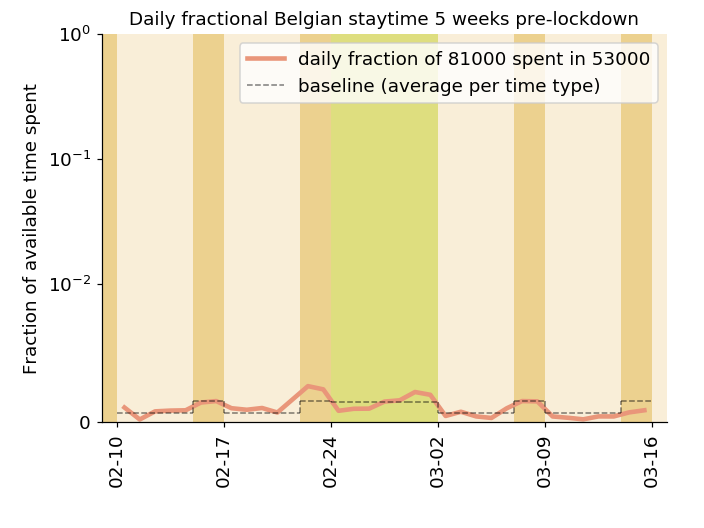

In [10]:
# Plotting environment

import matplotlib.dates as mdates
fontsize=12
color='darksalmon'
data_label=f'daily fraction of {NIS_from} spent in {NIS_to}'
symlog=True
    
fig, ax1 = plt.subplots()
ax1.grid(False)

ax1.set_ylabel('Fraction of available time spent', fontsize=fontsize)
ax1.tick_params(axis='y', labelsize=fontsize)
# ax1.set_xlabel('Date', fontsize=fontsize)
ax1.tick_params(axis='x', labelsize=fontsize)
myFmt = mdates.DateFormatter('%m-%d')
ax1.xaxis.set_major_formatter(myFmt)
ax1.set_xlim([dates_prelockdown_datetime[0]-timedelta(1), dates_prelockdown_datetime[-1]+timedelta(2)])
xticks_prelockdown = dates_prelockdown_datetime[0:-1:7] + [dates_prelockdown_datetime[-1]+timedelta(1)]
ax1.set_xticks(xticks_prelockdown)
ax1.set_ylim(0, 1)

if symlog:
    linthresh_power = -2
    ax1.set_yscale('symlog', linthreshy=10**linthresh_power)
    ax1.set_yticks([0]+[10**i for i in range(linthresh_power, 1, 1)])

# Shift 12 hours to the right for a nicer visualisation
dates_prelockdown_xaxis_shifted = np.array(dates_prelockdown_xaxis)+timedelta(hours=12)
ax1.plot(dates_prelockdown_xaxis_shifted, fractions, label=data_label, color=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.title('Daily fractional Belgian staytime 5 weeks pre-lockdown', fontsize=fontsize)
fig.autofmt_xdate(bottom=.2, rotation=90, ha='center', which=None) # Automatic x-tick fix!

# Add coloured bands
week_colour = 'wheat'
weekend_colour = 'goldenrod'
vacation_colour = 'y'
week_baseline_colour = 'k'
weekend_baseline_colour = 'k'
vacation_baseline_colour = 'k'
alpha=0.5
linewidth=1
baseline_alpha=0.5
label_baseline='baseline (average per time type)'

# Business days
plt.axvspan(sdate + timedelta(0), sdate + timedelta(5), facecolor=week_colour, alpha=alpha)
plt.plot((sdate + timedelta(0), sdate + timedelta(5)), (business_baseline, business_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.axvspan(sdate + timedelta(7), sdate + timedelta(12), facecolor=week_colour, alpha=alpha)
plt.plot((sdate + timedelta(7), sdate + timedelta(12)), (business_baseline, business_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.axvspan(sdate + timedelta(21), sdate + timedelta(26), facecolor=week_colour, alpha=alpha)
plt.plot((sdate + timedelta(21), sdate + timedelta(26)), (business_baseline, business_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.axvspan(sdate + timedelta(28), sdate + timedelta(33), facecolor=week_colour, alpha=alpha)
plt.plot((sdate + timedelta(28), sdate + timedelta(33)), (business_baseline, business_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)

# Weekends
plt.axvspan(sdate + timedelta(5), sdate + timedelta(7), facecolor=weekend_colour, alpha=alpha)
plt.plot((sdate + timedelta(5), sdate + timedelta(7)), (weekend_baseline, weekend_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.axvspan(sdate + timedelta(12), sdate + timedelta(14), facecolor=weekend_colour, alpha=alpha)
plt.plot((sdate + timedelta(12), sdate + timedelta(14)), (weekend_baseline, weekend_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.axvspan(sdate + timedelta(26), sdate + timedelta(28), facecolor=weekend_colour, alpha=alpha)
plt.plot((sdate + timedelta(26), sdate + timedelta(28)), (weekend_baseline, weekend_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.axvspan(sdate + timedelta(33), sdate + timedelta(35), facecolor=weekend_colour, alpha=alpha)
plt.plot((sdate + timedelta(33), sdate + timedelta(35)), (weekend_baseline, weekend_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)

# Vacation days
plt.axvspan(sdate + timedelta(14), sdate + timedelta(19), facecolor=vacation_colour, alpha=alpha)
plt.plot((sdate + timedelta(14), sdate + timedelta(19)), (vacation_baseline, vacation_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.axvspan(sdate + timedelta(19), sdate + timedelta(21), facecolor=vacation_colour, alpha=alpha)
plt.plot((sdate + timedelta(19), sdate + timedelta(21)), (vacation_baseline, vacation_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)

# Inbetween dotted lines (aesthetical)
plt.plot((sdate + timedelta(5), sdate + timedelta(5)), (business_baseline, weekend_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha, label=label_baseline)
plt.plot((sdate + timedelta(7), sdate + timedelta(7)), (weekend_baseline, business_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.plot((sdate + timedelta(12), sdate + timedelta(12)), (business_baseline, weekend_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.plot((sdate + timedelta(14), sdate + timedelta(14)), (weekend_baseline, vacation_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.plot((sdate + timedelta(21), sdate + timedelta(21)), (vacation_baseline, business_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.plot((sdate + timedelta(26), sdate + timedelta(26)), (business_baseline, weekend_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.plot((sdate + timedelta(28), sdate + timedelta(28)), (weekend_baseline, business_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.plot((sdate + timedelta(33), sdate + timedelta(33)), (business_baseline, weekend_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)

# Edges
plt.axvspan(sdate + timedelta(35), sdate + timedelta(36), facecolor=week_colour, alpha=alpha)
plt.axvspan(sdate + timedelta(-2), sdate + timedelta(0), facecolor=weekend_colour, alpha=alpha)

plt.legend(fontsize=fontsize)
plt.show()

# Visualising post-lockdown

In [11]:
# Load the data

### FILL IN AGGREGATION ###

agg = 'arr'
filename = 'fractional-mobility-matrix_staytime_' + agg + '_'
data_location = '../../data/interim/mobility/' + agg + '/staytime/'

from datetime import date, datetime, timedelta
dates_postlockdown=[]
dates_postlockdown_datetime=[]

# Define date range we want to load and plot
sdate_postlockdown = datetime(2020, 3, 16, 0, 0)   # start date
edate_postlockdown = datetime(2021, 1, 31, 0, 0)   # end date
delta = edate_postlockdown - sdate_postlockdown                 # as timedelta

# Fill arrays with YYYYMMDD dates and datetime dates
for i in range(delta.days + 1):
    day = sdate_postlockdown + timedelta(days=i)
    dates_postlockdown_datetime.append(day)
    dates_postlockdown.append(date_to_YYYYMMDD(day))
    
# Load dictionary with YYYYMMDD dates as keys and P-matrices as values
mmprox_postlockdown, missing_dates = load_Pmatrix_staytime(dates_postlockdown, data_location, \
                                        complete=False, verbose=True, return_missing=True, agg=agg)

# date array for xaxis (takes care of missing dates: needs same number of elements in array!)
dates_postlockdown_xaxis = dates_postlockdown_datetime.copy()
for d in missing_dates:
    dates_postlockdown_xaxis.remove(date_to_YYYYMMDD(d, inverse=True))

... proceeding with 317 dates.
Loaded dataframe for date 20210127.    


In [12]:
# Defining values to plot in array

NIS_from = '11000'
NIS_to = '81000'

fractions=[]
for d in mmprox_postlockdown:
    fraction = mmprox_postlockdown[d].loc[NIS_from, NIS_to]
    fractions.append(fraction)
    
# Define baseline values for NIS couple
vacation_baseline = mmprox_baseline_vacation.loc[NIS_from, NIS_to]
business_baseline = mmprox_baseline_business.loc[NIS_from, NIS_to]
weekend_baseline = mmprox_baseline_weekend.loc[NIS_from, NIS_to]

<IPython.core.display.Javascript object>


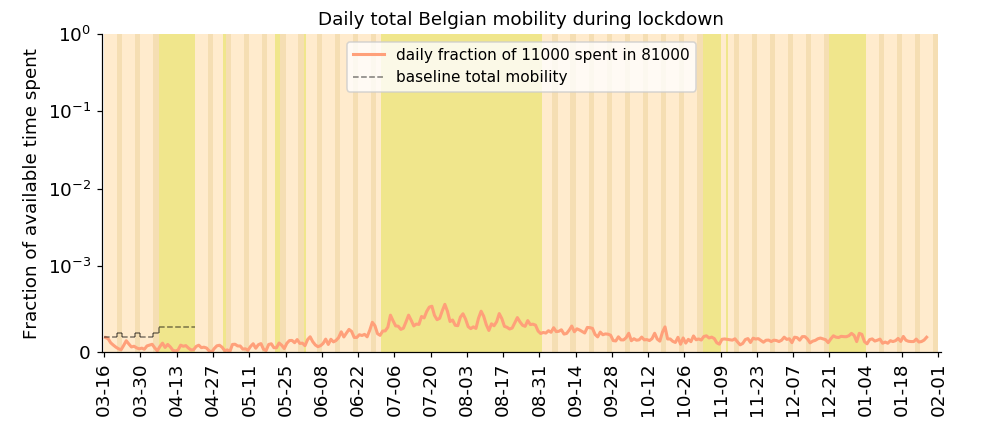

In [71]:
# Plotting environment
from covid19model.visualization.output import color_timeframes
import matplotlib.dates as mdates
import datetime
fontsize=12
color_daily='lightsalmon'
alpha_daily=1
color_averaged='darksalmon'
data_label=f'daily fraction of {NIS_from} spent in {NIS_to}'
symlog=True
tick_interval = 14 # days
    
fig, ax2 = plt.subplots(figsize=(9, 4))
ax2.grid(False)

ax2.set_ylabel('Fraction of available time spent', fontsize=fontsize)
ax2.tick_params(axis='y', labelsize=fontsize)
# ax2.set_xlabel('Date', fontsize=fontsize)
ax2.tick_params(axis='x', labelsize=fontsize)
myFmt = mdates.DateFormatter('%m-%d')
ax2.xaxis.set_major_formatter(myFmt)
ax2.set_xlim([dates_postlockdown_datetime[0]-datetime.timedelta(1), dates_postlockdown_datetime[-1]+datetime.timedelta(2)])
xticks_postlockdown = dates_postlockdown_datetime[0:-1:tick_interval] + [dates_postlockdown_datetime[-1]+datetime.timedelta(1)]
ax2.set_xticks(xticks_postlockdown)
ax2.set_ylim(0, 1)

if symlog:
    linthresh_power = -3
    ax2.set_yscale('symlog', linthreshy=10**linthresh_power)
    ax2.set_yticks([0]+[10**i for i in range(linthresh_power, 1, 1)])

dates_postlockdown_datetime_shifted = np.array(dates_postlockdown_xaxis)+datetime.timedelta(hours=12)
ax2.plot(dates_postlockdown_datetime_shifted, fractions, label=data_label, alpha=alpha_daily, linewidth=2,color=color_daily)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.title('Daily total Belgian mobility during lockdown', fontsize=fontsize)
fig.autofmt_xdate(bottom=.2, rotation=90, ha='center', which=None) # Automatic x-tick fix!

# Add coloured bands
week_baseline_colour = 'k'
weekend_baseline_colour = 'k'
vacation_baseline_colour = 'k'
alpha=0.5
linewidth=1
baseline_alpha=0.5
label_baseline='baseline total mobility'

# Draw background
color_timeframes(sdate_postlockdown, edate_postlockdown, ax=ax2)

# Business days
plt.plot((sdate_postlockdown + datetime.timedelta(0), sdate_postlockdown + datetime.timedelta(5)), (business_baseline, business_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.plot((sdate_postlockdown + datetime.timedelta(7), sdate_postlockdown + datetime.timedelta(12)), (business_baseline, business_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.plot((sdate_postlockdown + datetime.timedelta(14), sdate_postlockdown + datetime.timedelta(19)), (business_baseline, business_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
# plt.plot((sdate_postlockdown + datetime.timedelta(28), sdate_postlockdown + datetime.timedelta(33)), (business_baseline, business_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)

# Weekends
plt.plot((sdate_postlockdown + datetime.timedelta(5), sdate_postlockdown + datetime.timedelta(7)), (weekend_baseline, weekend_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.plot((sdate_postlockdown + datetime.timedelta(12), sdate_postlockdown + datetime.timedelta(14)), (weekend_baseline, weekend_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.plot((sdate_postlockdown + datetime.timedelta(19), sdate_postlockdown + datetime.timedelta(21)), (weekend_baseline, weekend_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
# plt.plot((sdate_postlockdown + datetime.timedelta(26), sdate_postlockdown + datetime.timedelta(28)), (weekend_baseline, weekend_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
# plt.plot((sdate_postlockdown + datetime.timedelta(33), sdate_postlockdown + datetime.timedelta(35)), (weekend_baseline, weekend_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)

# Vacation days
plt.plot((sdate_postlockdown + datetime.timedelta(21), sdate_postlockdown + datetime.timedelta(35)), (vacation_baseline, vacation_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)

# Inbetween dotted lines (aesthetical)
plt.plot((sdate_postlockdown + datetime.timedelta(5), sdate_postlockdown + datetime.timedelta(5)), (business_baseline, weekend_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha, label=label_baseline)
plt.plot((sdate_postlockdown + datetime.timedelta(7), sdate_postlockdown + datetime.timedelta(7)), (weekend_baseline, business_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.plot((sdate_postlockdown + datetime.timedelta(12), sdate_postlockdown + datetime.timedelta(12)), (business_baseline, weekend_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.plot((sdate_postlockdown + datetime.timedelta(14), sdate_postlockdown + datetime.timedelta(14)), (weekend_baseline, business_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.plot((sdate_postlockdown + datetime.timedelta(19), sdate_postlockdown + datetime.timedelta(19)), (weekend_baseline, business_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.plot((sdate_postlockdown + datetime.timedelta(21), sdate_postlockdown + datetime.timedelta(21)), (weekend_baseline, vacation_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)

# Edges
# plt.axvspan(sdate_postlockdown + datetime.timedelta(35), sdate_postlockdown + datetime.timedelta(36), facecolor=week_colour, alpha=alpha)
# plt.axvspan(sdate_postlockdown + datetime.timedelta(-2), sdate_postlockdown + datetime.timedelta(0), facecolor=weekend_colour, alpha=alpha)

plt.legend(fontsize=fontsize-2)#, bbox_to_anchor=(.98, .9), loc='center right')

In [81]:
if 1 in [1, 2]: print('yes')

yes
